## F770W - AMACS0723 - skysub

Author: Karl Gordon

Last modified: 10 Aug 2022

### Variables controling processing and display

In [1]:
filter = "F770W"
fwhm = 2.2
exclude_above = None
ds9regions = None
exclude_delta = 1.0

crval = [110.8261940446365, -73.45398878295636]
# rotation = 63.0
# crval = None
rotation = None

tweakreg = False
align_to_gaia = False

matchbkg = False
scalebkg = False

# display range for images
drange_cal = [-0.1, 5.0]
dmap = "afmhot"  # same as ds9 bb

run_cc_image3 = True

In [2]:
import os
import glob
import copy

from astropy.io import ascii, fits
from astropy.visualization import simple_norm

In [3]:
import astropy
print(astropy.__version__)

5.0.4


In [4]:
os.environ["CRDS_PATH"] = "/home/kgordon/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds-pub.stsci.edu"

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [6]:
# List of possible data quality flags
from jwst.datamodels import dqflags
from jwst import datamodels

from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

# custom helper routines
from helpers.jwst_helpers import show_image
from helpers.miri_clean import make_sky
from helpers.miri_helpers import miri_image3

In [7]:
import jwst
print(jwst.__version__)

1.6.2.dev4+g35d5e1d


## Make a sky and subtract it

In [8]:
miri_cal_files = glob.glob(f"./{filter}/stage2/*ge_fixed_wcs_cal.fits")
simage = make_sky(miri_cal_files, exclude_above=exclude_above, ds9regions=ds9regions, 
                  exclude_delta=exclude_delta, scalebkg=scalebkg)

processing ./F770W/stage2/jw02736002001_02101_00009_mirimage_fixed_wcs_cal.fits
median sky = 5.301723480224609
processing ./F770W/stage2/jw02736002001_02101_00006_mirimage_fixed_wcs_cal.fits
median sky = 5.303872585296631
processing ./F770W/stage2/jw02736002001_02101_00005_mirimage_fixed_wcs_cal.fits
median sky = 5.301525592803955
processing ./F770W/stage2/jw02736002001_02101_00008_mirimage_fixed_wcs_cal.fits
median sky = 5.304873466491699
processing ./F770W/stage2/jw02736002001_02101_00010_mirimage_fixed_wcs_cal.fits
median sky = 5.301459312438965
processing ./F770W/stage2/jw02736002001_02101_00002_mirimage_fixed_wcs_cal.fits
median sky = 5.301798343658447
processing ./F770W/stage2/jw02736002001_02101_00001_mirimage_fixed_wcs_cal.fits
median sky = 5.291842460632324
processing ./F770W/stage2/jw02736002001_02101_00004_mirimage_fixed_wcs_cal.fits
median sky = 5.306301116943359
processing ./F770W/stage2/jw02736002001_02101_00003_mirimage_fixed_wcs_cal.fits
median sky = 5.3034443855285645


2022-08-10 10:17:54,743 - stpipe - WARNING - /user/kgordon/anaconda3/envs/jwstdev/lib/python3.10/site-packages/astropy/stats/sigma_clipping.py:348: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



median sky = 5.302659034729004
Not scaling individual images to median bkg


2022-08-10 10:17:55,363 - stpipe - WARNING - /user/kgordon/anaconda3/envs/jwstdev/lib/python3.10/site-packages/astropy/stats/sigma_clipping.py:957: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)

2022-08-10 10:17:56,257 - stpipe - WARNING - /user/kgordon/anaconda3/envs/jwstdev/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,

2022-08-10 10:17:56,520 - stpipe - WARNING - /user/kgordon/anaconda3/envs/jwstdev/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



./F770W/stage2/jw02736002001_02101_00009_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00006_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00005_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00008_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00010_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00002_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00001_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00004_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00003_mirimage_fixed_wcs_cal.fits
./F770W/stage2/jw02736002001_02101_00007_mirimage_fixed_wcs_cal.fits


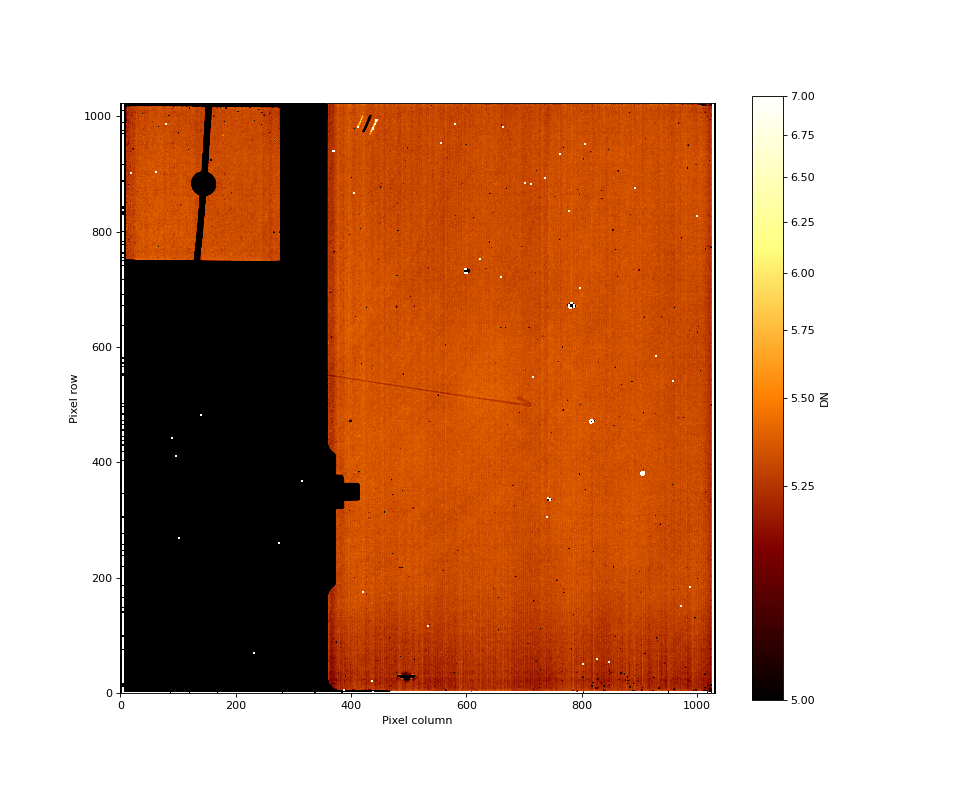

In [16]:
show_image(simage, 5, 7., dmap=dmap)
fits.writeto(f"./{filter}/stage3/{filter}_sky.fits", simage, overwrite=True)

### rerun CALWEBB_IMAGE3 with the new cleaned files

In [10]:
if run_cc_image3:
    miri_cccal_files = glob.glob(f"./{filter}/stage2/*ge_fixed_wcs_skysub_cal.fits")
    output_dir = f"./{filter}/stage3/"
    print(miri_cccal_files)

    if rotation is not None:
        miri_asn_name = f'miri_{filter}_stage3_nirproj_asn_skysub'
    else: 
        miri_asn_name = f'miri_{filter}_stage3_asn_skysub'    
    miri_asn = asn_from_list.asn_from_list(miri_cccal_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

    miri_asn_file = f'{miri_asn_name}.json'
    with open(miri_asn_file, 'w') as outfile:
        name, serialized = miri_asn.dump(format='json')
        outfile.write(serialized)

['./F770W/stage2/jw02736002001_02101_00002_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00008_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00001_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00010_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00005_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00009_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00006_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00007_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00004_mirimage_fixed_wcs_skysub_cal.fits', './F770W/stage2/jw02736002001_02101_00003_mirimage_fixed_wcs_skysub_cal.fits']


In [11]:
if run_cc_image3:
    miri_image3(miri_asn_file, output_dir, fwhm=fwhm, matchbkg=matchbkg,
                crval=crval, rotation=rotation,
                tweakreg=tweakreg, align_to_gaia=align_to_gaia)

2022-08-10 10:18:11,320 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-08-10 10:18:11,322 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': None, 'class': ''}


2022-08-10 10:18:11,323 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-08-10 10:18:11,326 - stpipe - CRITICAL - config: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_re

2022-08-10 10:18:12,001 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2022-08-10 10:18:12,003 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...
2022-08-10 10:18:14,271 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).
2022-08-10 10:18:14,273 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.2, 'snr_threshold': 5, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 5.0, 'use2dhist': True, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 

2022-08-10 10:18:47,454 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F770W/stage3/jw02736002001_02101_00004_mirimage_fixed_wcs_skysub_a3001_crf.fits
2022-08-10 10:18:48,454 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F770W/stage3/jw02736002001_02101_00003_mirimage_fixed_wcs_skysub_a3001_crf.fits
2022-08-10 10:18:48,455 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-08-10 10:18:48,611 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).
2022-08-10 10:18:48,612 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_

2022-08-10 10:19:31,254 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 170 sources
2022-08-10 10:19:31,579 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: ./F770W/stage3/miri_F770W_stage3_asn_skysub_cat.ecsv
2022-08-10 10:19:31,807 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in ./F770W/stage3/miri_F770W_stage3_asn_skysub_segm.fits
2022-08-10 10:19:31,808 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: miri_F770W_stage3_asn_skysub_segm.fits
2022-08-10 10:19:31,809 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done
2022-08-10 10:19:31,810 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


In [12]:
# Look at the resulting mosaic image
miri_mosaic_file = output_dir + miri_asn_name + '_i2d.fits'
miri_mosaic = datamodels.open(miri_mosaic_file)

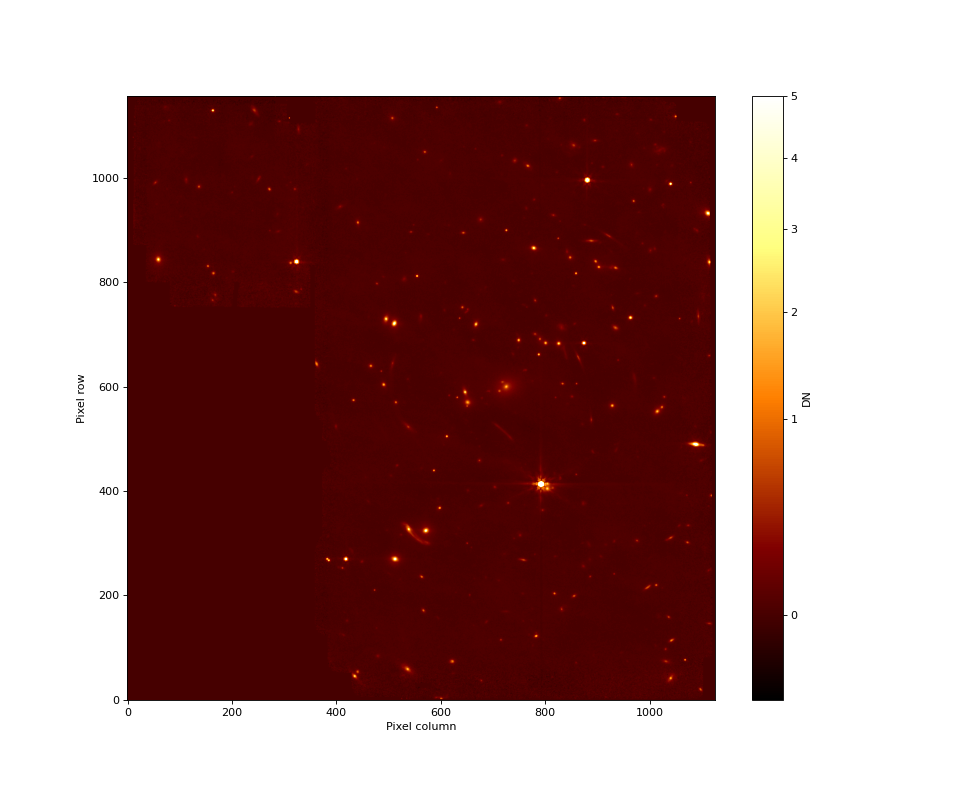

In [13]:
drange = drange_cal
# Look at the mosaic
show_image(miri_mosaic.data, vmin=drange[0], vmax=drange[1], dmap=dmap)